In [1]:
# https://www.rdkit.org/
import rdkit
#https://github.com/rdkit/rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np

#https://github.com/mordred-descriptor/mordred
#from mordred import Calculator, descriptors

from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
#---------------------- RDKit packages
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
#------------------- progress bar
from tqdm import tqdm
#------------------- hide warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
from rdkit.Chem.Draw import IPythonConsole
from ipywidgets import interact,fixed,IntSlider

In [4]:
def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol,bid,bitInfo)))
def get_index_of_array_that_contain_1_in_any_position(list1):
    result = []
    for i, e in enumerate(list1):
        if e > 0:
            result.append(i)
    return result

In [5]:
name1 = "CCCC(C)O"
m1 = Chem.MolFromSmiles(name1)
name2 = "CCC(CC)O"
m2 = Chem.MolFromSmiles(name2)

# Inspect Bit with Image

In [6]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint

mol1 = Chem.MolFromSmiles('CO')
mol2 = Chem.MolFromSmiles('CCO')
mol3 = Chem.MolFromSmiles('CCCO')
mol4 = Chem.MolFromSmiles('CCCCO')
bit_info1 = {}
bit_info2 = {}
bit_info3 = {}
bit_info4 = {}
fp1 = GetHashedMorganFingerprint(mol1, 3, bitInfo=bit_info1, useFeatures=True)
fp2 = GetHashedMorganFingerprint(mol2, 3, bitInfo=bit_info2, useFeatures=True)
fp3 = GetHashedMorganFingerprint(mol3, 3, bitInfo=bit_info3, useFeatures=True)
fp4 = GetHashedMorganFingerprint(mol4, 3, bitInfo=bit_info4, useFeatures=True)

In [7]:
print(get_index_of_array_that_contain_1_in_any_position(list(fp1)))
print(get_index_of_array_that_contain_1_in_any_position(list(fp2)))
print(get_index_of_array_that_contain_1_in_any_position(list(fp3)))
print(get_index_of_array_that_contain_1_in_any_position(list(fp4)))

[0, 3, 1230]
[0, 3, 805, 1085, 2041]
[0, 3, 490, 792, 805, 1085, 2041]
[0, 3, 490, 539, 545, 792, 805, 1085, 2041]


In [8]:
interact(renderFpBit, bitIdx=list(bit_info1.keys()),mol=fixed(mol1),
         bitInfo=fixed(bit_info1),fn=fixed(Draw.DrawMorganBit));
interact(renderFpBit, bitIdx=list(bit_info2.keys()),mol=fixed(mol2),
         bitInfo=fixed(bit_info2),fn=fixed(Draw.DrawMorganBit));
interact(renderFpBit, bitIdx=list(bit_info3.keys()),mol=fixed(mol3),
         bitInfo=fixed(bit_info3),fn=fixed(Draw.DrawMorganBit));
interact(renderFpBit, bitIdx=list(bit_info4.keys()),mol=fixed(mol4),
         bitInfo=fixed(bit_info4),fn=fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(0, 3, 1230), value=0), Output()), _dom_classes=(…

interactive(children=(Dropdown(description='bitIdx', options=(0, 3, 805, 1085, 2041), value=0), Output()), _do…

interactive(children=(Dropdown(description='bitIdx', options=(0, 3, 490, 792, 805, 1085, 2041), value=0), Outp…

interactive(children=(Dropdown(description='bitIdx', options=(0, 3, 490, 539, 545, 792, 805, 1085, 2041), valu…

# Bit No.352 is *-CCC(C)O

In [9]:
bit_info = {}
mol = m1
fp = GetHashedMorganFingerprint(mol, 3, bitInfo=bit_info, useFeatures=True)

In [10]:
print(get_index_of_array_that_contain_1_in_any_position(list(fp)))

[0, 3, 352, 539, 792, 1085, 1587, 1687, 2041]


In [11]:
# Select Bit
atomidx, radius = bit_info[352][0]

In [12]:
# Inspect Bit
bit_info_mol = {}
fp_mol = GetHashedMorganFingerprint(mol, 3, bitInfo=bit_info_mol, useFeatures=True)
interact(renderFpBit, bitIdx=list(bit_info_mol.keys()),mol=fixed(mol),
         bitInfo=fixed(bit_info_mol),fn=fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(0, 3, 352, 539, 792, 1085, 1587, 1687, 2041), va…

In [13]:
env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atomidx)

atomsToUse = set((atomidx, ))
for b in env:
    atomsToUse.add(mol.GetBondWithIdx(b).GetBeginAtomIdx())
    atomsToUse.add(mol.GetBondWithIdx(b).GetEndAtomIdx())

enlargedEnv = set()
for atom in atomsToUse:
    a = mol.GetAtomWithIdx(atom)
    for b in a.GetBonds():
      bidx = b.GetIdx()
      if bidx not in env:
        enlargedEnv.add(bidx)

enlargedEnv = list(enlargedEnv)
enlargedEnv += env

# find all relevant neighbors
anyAtoms = []
for a in atomsToUse:
    neighbors = mol.GetAtomWithIdx(a).GetNeighbors()
    for n in neighbors:
        anyIdx = n.GetIdx()
        if anyIdx not in atomsToUse:
            anyAtoms.append(anyIdx)

# replace atomic number to zero (there is no number for any atom)
for aA in anyAtoms:
    mol.GetAtomWithIdx(aA).SetAtomicNum(0)

submol = Chem.PathToSubmol(mol, enlargedEnv)

# change [0] to *
MorganBitSmarts = Chem.MolToSmarts(submol).replace('[#0]', '*')
print(MorganBitSmarts)

*-[#6]-[#6]-[#6](-[#6])-[#8]


# Inspect All Bit in Molecule

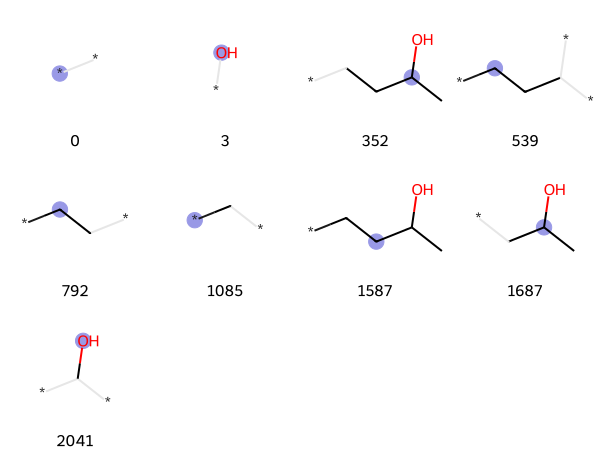

In [14]:
# Inspect Bit
mol = m1
bit_info_mol = {}
fp_mol = GetHashedMorganFingerprint(mol, 3, bitInfo=bit_info_mol, useFeatures=True)
all_fragments = [(mol, x, bit_info_mol) for x in get_index_of_array_that_contain_1_in_any_position(list(fp_mol))]
Draw.DrawMorganBits(all_fragments[:], molsPerRow=4, legends=[str(x) for x in get_index_of_array_that_contain_1_in_any_position(list(fp_mol))][:])